In [1]:
#Cargar Librerías
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import csv
%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('fast')

from sklearn.metrics import r2_score
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import LSTM

In [2]:
#SACAR R2 ENTRE VALOR PREDIJO (EL MAS CERCANO, EL MÍNIMO) VS REAL
#AGREGAR VARIABLE "MARCA" AGRUPANDO CON LOS MÁS SIGINFICATIVOS Y "OTROS"

In [3]:
#Cargar archivo .CSV con datos de delitos
#Si es necesario, aún no se puede agregar más variables

df = pd.read_csv("/Users/j.artigasalegra/Documents/tesis/Solicitud_Base_Datos/Base_Dato_Con_Coorednadas/DATOS GEOCODIFICADOS/DATOS_RED_CUADRANTE.csv",  parse_dates=[0], index_col=0, names=['Delito','DiaSem', 'Mes', 'Hora', 'TipoV','Marca', 'Comuna', 'Cuadrante'])
df.head(10)

DiaSem  Mes  Hora  TipoV  Marca  Comuna  Cuadrante
Delito                                                    
1            3    1     1      2      2       5         21
3            3    1     5      1      1       2          1
4            3    1     5      4     17       1         12
5            3    1     6      1      2       4          1
6            3    1     8      1      5       1          2
7            3    1     9      3      3       2          8
8            3    1    11      5     10       3         23
9            3    1    13      1      2       1          4
10           3    1    22      2      7       1          6
12           4    1     0      1      1      12          1

In [4]:
df.describe()

DiaSem          Mes         Hora        TipoV        Marca  \
count  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000   
mean      4.003848     6.432106    11.626443     2.015393     6.886201   
std       1.977461     3.434077     7.475914     1.549046     6.018642   
min       1.000000     1.000000     0.000000     1.000000     1.000000   
25%       2.000000     4.000000     5.000000     1.000000     2.000000   
50%       4.000000     6.000000    11.000000     1.000000     4.000000   
75%       6.000000     9.000000    19.000000     3.000000    12.000000   
max       7.000000    12.000000    23.000000     6.000000    17.000000   

            Comuna    Cuadrante  
count  3638.000000  3638.000000  
mean      3.319956     7.767180  
std       2.973699     6.358457  
min       1.000000     1.000000  
25%       1.000000     2.000000  
50%       2.000000     6.000000  
75%       5.000000    11.000000  
max      12.000000    25.000000

In [5]:
df=df.drop(columns=[])
print(df.shape)
df.head()

(3638, 7)


DiaSem  Mes  Hora  TipoV  Marca  Comuna  Cuadrante
Delito                                                    
1            3    1     1      2      2       5         21
3            3    1     5      1      1       2          1
4            3    1     5      4     17       1         12
5            3    1     6      1      2       4          1
6            3    1     8      1      5       1          2

In [6]:
# convertir series a aprendizaje supervizado
#Aprendizaje supervisado será utilizando los 15 días previos para predecir el actual delito (latitud y longitud)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
PASOS = 15

data = df.values
data = data.astype('float32')
scaler = MinMaxScaler()
data = scaler.fit_transform(data[:, :8])
data = pd.DataFrame(data)
data.columns = data.columns
data=data.rename(columns = {0:'Diasem', 1:'Mes', 2:'Hora', 3:'TipoV', 4:'Marca', 5:'Comuna', 6:'Cuadrante'})
data.head()

scaledMerge= data

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
print(reframed.shape)
reframed.head()

(3623, 112)


var1(t-15)  var2(t-15)  var3(t-15)  var4(t-15)  var5(t-15)  var6(t-15)  \
15    0.333333         0.0    0.043478         0.2      0.0625    0.363636   
16    0.333333         0.0    0.217391         0.0      0.0000    0.090909   
17    0.333333         0.0    0.217391         0.6      1.0000    0.000000   
18    0.333333         0.0    0.260870         0.0      0.0625    0.272727   
19    0.333333         0.0    0.347826         0.0      0.2500    0.000000   

    var7(t-15)  var1(t-14)  var2(t-14)  var3(t-14)  ...  var5(t-1)  var6(t-1)  \
15    0.833333    0.333333         0.0    0.217391  ...     0.4375   0.454545   
16    0.000000    0.333333         0.0    0.217391  ...     0.1250   0.090909   
17    0.458333    0.333333         0.0    0.260870  ...     0.0625   0.000000   
18    0.000000    0.333333         0.0    0.347826  ...     0.3750   0.090909   
19    0.041667    0.333333         0.0    0.391304  ...     1.0000   0.000000   

    var7(t-1)   var1(t)  var2(t)   var3(t)  var4(t)  var5(t)   var6(t)  \
15   0.041667  0.666667      0.0  0.782609      0.0   0.1250  0.090909   
16   0.000000  0.666667      0.0  0.913043      0.0   0.0625  0.000000   
17   0.000000  0.666667      0.0  0.956522      0.0   0.3750  0.090909   
18   0.000000  0.666667      0.0  0.956522      1.0   1.0000  0.000000   
19   0.416667  0.833333      0.0  0.173913      0.0   1.0000  0.181818   

     var7(t)  
15  0.000000  
16  0.000000  
17  0.000000  
18  0.416667  
19  0.333333  

[5 rows x 112 columns]

In [8]:
#Se elimina las otras variables en perido t para solo tener como salida Longitud y Latitud

newReframed=reframed.drop(columns=['var1(t)','var2(t)','var3(t)','var4(t)', 'var5(t)', 'var6(t)'])
print(newReframed.shape)
newReframed.head()

(3623, 106)


var1(t-15)  var2(t-15)  var3(t-15)  var4(t-15)  var5(t-15)  var6(t-15)  \
15    0.333333         0.0    0.043478         0.2      0.0625    0.363636   
16    0.333333         0.0    0.217391         0.0      0.0000    0.090909   
17    0.333333         0.0    0.217391         0.6      1.0000    0.000000   
18    0.333333         0.0    0.260870         0.0      0.0625    0.272727   
19    0.333333         0.0    0.347826         0.0      0.2500    0.000000   

    var7(t-15)  var1(t-14)  var2(t-14)  var3(t-14)  ...  var6(t-2)  var7(t-2)  \
15    0.833333    0.333333         0.0    0.217391  ...   0.000000   0.083333   
16    0.000000    0.333333         0.0    0.217391  ...   0.454545   0.041667   
17    0.458333    0.333333         0.0    0.260870  ...   0.090909   0.000000   
18    0.000000    0.333333         0.0    0.347826  ...   0.000000   0.000000   
19    0.041667    0.333333         0.0    0.391304  ...   0.090909   0.000000   

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
15   0.666667        0.0   0.782609        0.0     0.4375   0.454545   
16   0.666667        0.0   0.782609        0.0     0.1250   0.090909   
17   0.666667        0.0   0.913043        0.0     0.0625   0.000000   
18   0.666667        0.0   0.956522        0.0     0.3750   0.090909   
19   0.666667        0.0   0.956522        1.0     1.0000   0.000000   

    var7(t-1)   var7(t)  
15   0.041667  0.000000  
16   0.000000  0.000000  
17   0.000000  0.000000  
18   0.000000  0.416667  
19   0.416667  0.333333  

[5 rows x 106 columns]

In [9]:
#Separar datos como datos de entrenamiento y datos de prueba 
#Separa los datos en 80% (1700) train y 20% (725) validación

values = newReframed.values
train = values[0:3260, :]
test = values[3260:3628, :]

# split into input and outputs

x_train, y_train = train[:, 0:105], train[:, 105:106]
x_val, y_val = test[:, 0:105], test[:, 105:106]

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1,x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(3260, 1, 105) (3260, 1) (363, 1, 105) (363, 1)


In [10]:
#Se define la red neuronal, cuando tenga la red lista, probare con distintas funciones de activación o nodos

def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(105, input_dim=105, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mse"])
    model.summary()
    return model

In [11]:
#Despues de tener lista la red, variare EPOCHS para ver como mejoran los resultados
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 105)               88620     
_________________________________________________________________
dense (Dense)                (None, 1)                 106       
Total params: 88,726
Trainable params: 88,726
Non-trainable params: 0
_________________________________________________________________


W1107 23:31:29.196644 4502676928 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3260 samples, validate on 363 samples
Epoch 1/40
3260/3260 [==============================] - 16s 5ms/sample - loss: 0.2144 - mse: 0.0767 - val_loss: 0.2159 - val_mse: 0.0699
Epoch 2/40
3260/3260 [==============================] - 14s 4ms/sample - loss: 0.2127 - mse: 0.0755 - val_loss: 0.2184 - val_mse: 0.0804
Epoch 3/40
3260/3260 [==============================] - 14s 4ms/sample - loss: 0.2120 - mse: 0.0751 - val_loss: 0.2133 - val_mse: 0.0725
Epoch 4/40
3260/3260 [==============================] - 14s 4ms/sample - loss: 0.2115 - mse: 0.0743 - val_loss: 0.2165 - val_mse: 0.0770
Epoch 5/40
3260/3260 [==============================] - 14s 4ms/sample - loss: 0.2111 - mse: 0.0748 - val_loss: 0.2132 - val_mse: 0.0712
Epoch 6/40
3260/3260 [==============================] - 14s 4ms/sample - loss: 0.2096 - mse: 0.0740 - val_loss: 0.2141 - val_mse: 0.0726
Epoch 7/40
3260/3260 [==============================] - 16s 5ms/sample - loss: 0.2095 - mse: 0.0743 - val_loss: 0.2157 - val_mse: 0

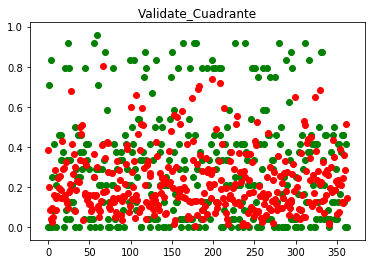

In [12]:
#Renombrar columnas de variable predicha y validación

results=model.predict(x_val)
results = pd.DataFrame(results)
results.columns = results.columns
results=results.rename(columns = {0:'Cuadrante'})
#print(results)

y_val = pd.DataFrame(y_val)
y_val.columns = y_val.columns
y_val=y_val.rename(columns = {0:'Cuadrante'})
#print(y_val)

#Permite visualizar que tanto se acerca la predicción con los valores de validación
plt.scatter(range(len(y_val['Cuadrante'])),y_val['Cuadrante'],c='g')
plt.scatter(range(len(results['Cuadrante'])),results['Cuadrante'],c='r')
plt.title('Validate_Cuadrante')
plt.show()

#plt.scatter(range(len(y_val['Latitud'])),y_val['Latitud'],c='g')
#plt.scatter(range(len(results['Latitud'])),results['Latitud'],c='r')
#plt.title('Validate_Latitud')
#plt.show()

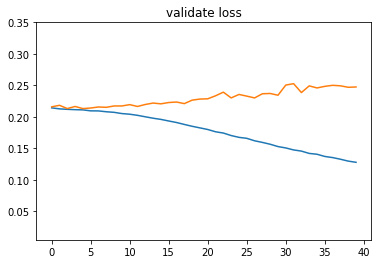

In [13]:
#Permite graficar la pérdida LOSS tanto del conjunto de ENTENAMIENTO(azul)  como de VALIDACION(naranja)

plt.ylim(0.005, 0.35)
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

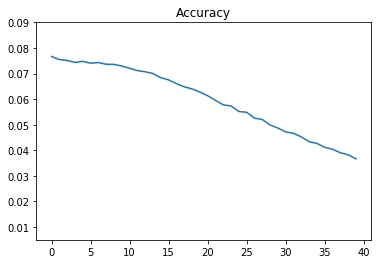

In [14]:
plt.ylim(0.005, 0.09)
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [15]:
print(results)

     Cuadrante
0     0.386269
1     0.201707
2     0.087338
3     0.042428
4     0.024482
5     0.096220
6     0.052008
7     0.159956
8     0.286173
9     0.145457
10    0.083329
11    0.155841
12    0.244460
13    0.193557
14    0.255682
15    0.143455
16    0.182959
17    0.429936
18    0.289263
19    0.292883
20    0.158170
21    0.324396
22    0.133558
23    0.120373
24    0.094343
25    0.173627
26    0.214298
27    0.184854
28    0.680692
29    0.416777
..         ...
333   0.324538
334   0.070929
335   0.134489
336   0.267713
337   0.159703
338   0.287102
339   0.261060
340   0.020858
341   0.017611
342   0.196040
343   0.299867
344   0.177205
345   0.434988
346   0.350600
347   0.184122
348   0.186807
349   0.228665
350   0.064750
351   0.213496
352   0.236450
353   0.075116
354   0.388960
355   0.211521
356   0.126615
357   0.245211
358   0.120212
359   0.361420
360   0.283576
361   0.514726
362   0.146473

[363 rows x 1 columns]


In [16]:
#Agregar 4 columnas falsasa para poder invertir valores a original

results['Var2'] = results['Cuadrante']
results['Var3'] = results['Cuadrante']
results['Var4'] = results['Cuadrante']
results['Var5'] = results['Cuadrante']
results['Var6'] = results['Cuadrante']
results['Var7'] = results['Cuadrante']
print(results)

y_val['Var2'] = y_val["Cuadrante"]
y_val['Var3'] = y_val["Cuadrante"]
y_val['Var4'] = y_val["Cuadrante"]
y_val['Var5'] = y_val["Cuadrante"]
y_val['Var6'] = y_val["Cuadrante"]
y_val['Var7'] = y_val["Cuadrante"]
print(y_val)

     Cuadrante      Var2      Var3      Var4      Var5      Var6      Var7
0     0.386269  0.386269  0.386269  0.386269  0.386269  0.386269  0.386269
1     0.201707  0.201707  0.201707  0.201707  0.201707  0.201707  0.201707
2     0.087338  0.087338  0.087338  0.087338  0.087338  0.087338  0.087338
3     0.042428  0.042428  0.042428  0.042428  0.042428  0.042428  0.042428
4     0.024482  0.024482  0.024482  0.024482  0.024482  0.024482  0.024482
5     0.096220  0.096220  0.096220  0.096220  0.096220  0.096220  0.096220
6     0.052008  0.052008  0.052008  0.052008  0.052008  0.052008  0.052008
7     0.159956  0.159956  0.159956  0.159956  0.159956  0.159956  0.159956
8     0.286173  0.286173  0.286173  0.286173  0.286173  0.286173  0.286173
9     0.145457  0.145457  0.145457  0.145457  0.145457  0.145457  0.145457
10    0.083329  0.083329  0.083329  0.083329  0.083329  0.083329  0.083329
11    0.155841  0.155841  0.155841  0.155841  0.155841  0.155841  0.155841
12    0.244460  0.244460 

In [17]:
#Primero se inviernten los valores de "y_val" y "results" a su valor original
inverted_res = scaler.inverse_transform(results.values)
compara_res = pd.DataFrame(inverted_res)

inverted_y_val = scaler.inverse_transform(y_val.values)
compara_y_val = pd.DataFrame(inverted_y_val)

#Segundo se asgina nombre a las columnas de cada variable
compara_y_val=compara_y_val.rename(columns = {0:'Falso1', 1:'Falso2', 2:'Falso3', 3:'Falso4', 4:'Falso5', 5:'Falso6', 6:'Cuadrante'})
compara_res=compara_res.rename(columns = {0:'Falso1', 1:'Falso2', 2:'Falso3', 3:'Falso4', 4:'Falso5', 5:'Falso6', 6:'Cuadrante'})

#Tercero se eliminan las variables no necesarias
compara_res = compara_res.drop(['Falso1', 'Falso2', 'Falso3', 'Falso4', 'Falso5', 'Falso6'], axis=1)
compara_y_val = compara_y_val.drop(['Falso1', 'Falso2', 'Falso3', 'Falso4', 'Falso5', 'Falso6'], axis=1)
#print(compara_y_val)
#print(compara_res)

#Cuarto crea variable "diferencia" entre valores de resultado y validación, tanto para longitud como latitud
diferencia_lon = compara_res['Cuadrante'] - compara_y_val['Cuadrante']
#diferencia_lat  = compara_res['Latitud'] - compara_y_val['Latitud']
print(diferencia_lon)
#print(diferencia_lat)

0       9.270455
1     -12.159040
2       2.096113
3     -18.981728
4      -5.412441
5       2.309280
6      -0.751819
7      -6.161051
8       4.868155
9      -1.509030
10      1.999892
11     -2.259820
12     -0.132958
13     -6.354642
14     -4.863637
15     -7.557086
16     -3.608979
17      2.318467
18     -2.057681
19      7.029195
20    -15.203924
21      6.785496
22      1.205393
23     -5.111055
24    -19.735756
25    -14.832943
26     -2.856857
27      3.436491
28     13.336620
29      5.002636
         ...    
333    -0.211089
334     0.702289
335    -1.772268
336    -4.574900
337    -7.167116
338     5.890439
339     4.265448
340    -0.499409
341     0.422667
342     3.704965
343    -1.803187
344     1.252920
345    -0.560280
346    -3.585612
347     1.418931
348     3.483356
349    -1.512050
350     0.554008
351    -4.876108
352     2.674797
353    -8.197205
354     5.335038
355    -3.923506
356    -7.961242
357    -5.114942
358    -8.114908
359     5.674082
360     6.8058

In [18]:
r2_score(compara_y_val, compara_res, multioutput='variance_weighted')

-0.4756967230343685

In [19]:
r2_score(compara_y_val['Cuadrante'], compara_res['Cuadrante'])

-0.4756967230343685

In [20]:
#r2_score(compara_y_val['Latitud'], compara_res['Latitud'])

In [21]:
#Compara Longitudes reales, predichos y su diferencia.
compara_lon = pd.DataFrame(np.array([compara_y_val['Cuadrante'], compara_res['Cuadrante']])).transpose()
compara_lon.columns = ['real', 'prediccion']

compara_lon2 = pd.DataFrame(compara_lon)
compara_lon2.columns = ['real', 'prediccion']
compara_lon2['diferencia'] = diferencia_lon
compara_lon2.head(10)

real  prediccion  diferencia
0   1.0   10.270455    9.270455
1  18.0    5.840960  -12.159040
2   1.0    3.096113    2.096113
3  21.0    2.018273  -18.981728
4   7.0    1.587560   -5.412441
5   1.0    3.309280    2.309280
6   3.0    2.248181   -0.751819
7  11.0    4.838949   -6.161051
8   3.0    7.868155    4.868155
9   6.0    4.490970   -1.509030

In [22]:
#Compara Latitudes reales, predichos y su diferencia.
#compara_lat = pd.DataFrame(np.array([compara_y_val['Latitud'], compara_res['Latitud']])).transpose()
#compara_lat.columns = ['real', 'prediccion']

#compara_lat2 = pd.DataFrame(compara_lat)
#compara_lat2.columns = ['real', 'prediccion']
#compara_lat2['diferencia'] = diferencia_lat
#compara_lat2.head(10)

In [23]:
#Descarga archivo .CSV con predicción de longitud y latitud

prediccion_lon = pd.DataFrame(compara_lon2)
prediccion_lon.to_csv('LSTM_7v_15d_40e_pronostico_Cuadrante.csv')

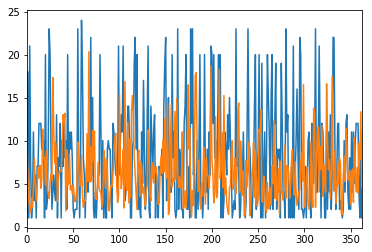

In [24]:
#Gráfico de los resultados de la predicción versus los datos reales
#de variable "Longitud del delito"

compara_lon['real'].plot() #Color azul
compara_lon['prediccion'].plot() #Color naranjo